In [340]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt 
from math import floor

In [ ]:
#TODO: Add perlin noise value that sweeps over the range of the communities
#      to simulate the effect of a changing popularity of communities over time

In [341]:
communities = 0
groups = 0

In [342]:
# A community is more of an abstract idea where similar groups may belong to the same community
# if they share topics or have a larger overlap of people
class Community:
    def __init__(self, group=None):
        # Initialize a community with a list of users and groups
        self.id = len(communities) + 1
        self.groups = [group] if group else []
        self.interactions = []

# A group has many users that belong to it and can comment within it
class Group:
    def __init__(self):
        # Initialize a group with an ID and a dictionary tgo track user interactions
        self.id = len(groups) + 1
        self.interactions = {}
        self.community : Community = None

    def join_community(self, community : Community):
        community.groups.append(self)
        self.community = community

# Defines what a user is, and how they interact with groups
class User:
    def __init__(self, group_alpha, group_beta, community_alpha, community_beta):
        # Initialize a user with ID, group memberships, interaction history, and Beta distribution preferences
        self.id = None

        self.groups = []
        self.communities = []
        self.interaction_history = []

        self.group_preferences = stats.beta(group_alpha, group_beta)
        self.community_preferences = stats.beta(community_alpha, community_beta)
        self.updated_preferences = np.array([1])

    def update_preferences(self):
        # Update user's preferences based on group interactions
        if not self.groups:
            self.updated_preferences = np.array([1])
            return
        else:
            #sort groups by number of interactions
            self.groups.sort(key=lambda group: len(group.interactions))

        total_size = sum([len(group.interactions) for group in self.groups])

        # if size is 0, this must be the first iteration, return uniform
        if total_size == 0:
            self.ccdf = np.array([1])
            return
        else:
            sizes = sorted([len(group.interactions) for group in self.groups])
            self.ccdf = 1 - (np.cumsum(sizes) / total_size)

        group_convolution = np.convolve(self.group_preferences.pdf(np.linspace(0, 1, len(self.groups))), self.ccdf , mode='same')

        self.updated_preferences = np.convolve(group_convolution, self.community_preferences.pdf(np.linspace(0, 1, len(self.groups))), mode='same')

        if np.isnan(self.updated_preferences).any() or np.sum(self.updated_preferences) == 0:
            self.updated_preferences = np.array([1 / len(self.groups)] * len(self.groups))
        else:
            self.updated_preferences /= np.sum(self.updated_preferences)

    def join_group(self, group):
        # Add a group to the user's group list and set initial interactions to 0
        self.groups.append(group)
        group.interactions[self] = 0

    def interact(self, group: Group):
        # Record an interaction with the specified group
        group.interactions[self] = group.interactions.get(self, 0) + 1
        self.interaction_history.append(group.id)

In [343]:
# Simulation parameters
num_timesteps = 1000

# main_rate = None
user_growth_rate = 2
same_community_interaction_rate = 0.1

new_group_rate = 0.75
join_new_community_chance = 0.1 # technically the first group of a new community
new_community_chance = 0.05
new_group_join_chance = 0.1

interaction_threshold = 1

## hyperparameters
# max values for the beta distribution
alpha_group_hyperparameter = 10
beta_group_hyperparameter = 10 

# same for community
alpha_community_hyperparameter = 10
beta_community_hyperparameter = 10

initial_users = 20
initial_groups = 10
initial_communities = 3

Mean of the distribution is:  0.049998527433084174


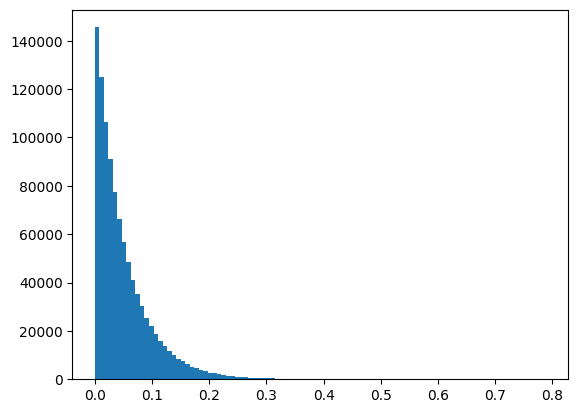

In [344]:
# plotting User_growth_rate distribution
x = np.linspace(0, 10, 10)
# using numpy.random.exponential
vals = np.random.exponential(new_community_chance, 1000000)
# printing mean
print("Mean of the distribution is: ", np.mean(vals))
# plotting the distribution
plt.hist(vals, 100)
plt.show()

In [345]:
# Initialize lists to store users and groups
users = []
groups = []
communities = []

user_interactions = []
group_interactions = []
community_interactions = []

# Initialize users
for i in range(initial_users):
    users.append(
        User(
            alpha_group_hyperparameter,
            beta_group_hyperparameter,
            alpha_community_hyperparameter,
            beta_community_hyperparameter,
        )
    )
    users[-1].id = len(users)

# Initialize communities
for i in range(initial_communities):
    communities.append(Community())

# Initialize groups
for i in range(initial_groups):
    groups.append(Group())

# adding the first groups to each community so there is at least one group in each community
for i in range(len(communities)):
    groups[i].join_community(communities[i])
    # random chance for each user to join the first group of a new community
    for user in users:
        if np.random.random() < join_new_community_chance:
            user.join_group(groups[i])

# randomly adding the rest of the groups to communities
for group in groups[len(communities):]:
    group.join_community(communities[np.random.randint(0, len(communities))])
    for user in users:
        if np.random.random() < new_group_join_chance:
            user.join_group(group)

# Recalculate probabilities at every iteration or after any changes
def calculate_probabilities():
    global community_relative_frequency, group_relative_frequency

    community_relative_frequency = np.array([len(community.groups) for community in communities], dtype=float)
    # if community_relative_frequency.sum() != 0:
    community_relative_frequency += 1e-5  # Avoid division by zero
    community_relative_frequency /= community_relative_frequency.sum()

    group_relative_frequency = np.array([sum(group.interactions.values()) for group in groups], dtype=float)
    # if group_relative_frequency.sum() != 0:
    group_relative_frequency += 1e-5
    group_relative_frequency /= group_relative_frequency.sum()

gis = {}
cis = {}
uis = {}

# initialize dictionaries for each group, community, and user
for group in groups:
    gis[group.id] = []
for community in communities:
    cis[community.id] = []
for user in users:
    uis[user.id] = []

# main loop
for time in range(num_timesteps):
    if time % 10 == 0:
        print(f"Time: {time}")
    # Calculate probabilities
    calculate_probabilities()

    # Add new users
    new_users_count = floor(np.random.exponential(user_growth_rate))
    for i in range(new_users_count):
        users.append(
            User(
                alpha_group_hyperparameter,
                beta_group_hyperparameter,
                alpha_community_hyperparameter,
                beta_community_hyperparameter,
            )
        )
        users[-1].id = len(users)

    # Add new groups
    new_groups_count = floor(np.random.exponential(new_group_rate))
    for i in range(new_groups_count):
        groups.append(Group())

        # a new community always get made on the first time step
        if time == 0:
            if new_groups_count == 0:
                groups.append(Group())
            groups[-1].join_community(communities[-1])
            communities[-1].groups.append(groups[-1])
        else:
            # check if the new group forms a new community
            if np.random.random() < new_community_chance:
                communities.append(Community(groups[-1]))
                groups[-1].community = communities[-1]
                # each user has a chance to join the new community
                for user in users:
                    if np.random.random() < join_new_community_chance:
                        user.join_group(groups[-1])
                # users[np.random.randint(0, len(users))].join_group(groups[-1])
            else:
                # join a random community
                groups[-1].join_community(communities[np.random.randint(0, len(communities))])

    # Updating dictionaries with new groups, communities, and users
    # and setting their initial values to 0
    for group in groups:
        if group.id not in gis:
            gis[group.id] = [0]
        gis[group.id].append(0)
    for community in communities:
        if community.id not in cis:
            cis[community.id] = [0]
        cis[community.id].append(0)
    for user in users:
        if user.id not in uis:
            uis[user.id] = [0]
        uis[user.id].append(0)

    # Add new users to groups
    for user in users:
        calculate_probabilities()
        # if there are groups for the user to join that they aren't in
        if len(user.groups) < len(groups):
            # join a group
            if np.random.random() < new_group_join_chance:
                user.join_group(groups[np.random.choice(len(groups), p=group_relative_frequency)])

    # Interact with groups
    for user in users:
        user.update_preferences()
        interacted_groups = []
        if np.random.uniform() < interaction_threshold and user.groups:
            # print(user.updated_preferences)
            group = np.random.choice(user.groups, p=user.updated_preferences)
            user.interact(group)
            gis[group.id][-1] += 1
            cis[group.community.id][-1] += 1
            uis[user.id][-1] += 1

            # potential bonus interactions within another group in the same community
            if group.community:
                while True:
                    if np.random.uniform() < same_community_interaction_rate:
                        community = group.community                    
                        group = np.random.choice(community.groups)
                        user.interact(group)
                        gis[group.id][-1] += 1
                        cis[group.community.id][-1] += 1
                        uis[user.id][-1] += 1
                    else:
                        break

    # Update user preferences
    for user in users:
        if user.groups:
            user.update_preferences()
            if user.id == 0:
                print(user.updated_preferences)
                print(user.group_preferences.pdf(np.linspace(0, 1, len(user.groups))))
        else:
            user.updated_preferences = np.array([1])

print(gis)
print(cis)
print(uis)     

Time: 0
Time: 10
Time: 20
Time: 30
Time: 40
Time: 50
Time: 60
Time: 70
Time: 80
Time: 90
Time: 100
Time: 110
Time: 120
Time: 130
Time: 140
Time: 150
Time: 160
Time: 170
Time: 180
Time: 190
Time: 200
Time: 210
Time: 220
Time: 230
Time: 240
Time: 250
Time: 260
Time: 270
Time: 280
Time: 290
Time: 300
Time: 310
Time: 320
Time: 330
Time: 340
Time: 350
Time: 360
Time: 370
Time: 380
Time: 390
Time: 400
Time: 410
Time: 420
Time: 430
Time: 440
Time: 450
Time: 460
Time: 470
Time: 480
Time: 490
Time: 500
Time: 510
Time: 520
Time: 530
Time: 540
Time: 550
Time: 560
Time: 570
Time: 580
Time: 590
Time: 600
Time: 610
Time: 620
Time: 630
Time: 640
Time: 650
Time: 660
Time: 670
Time: 680
Time: 690
Time: 700
Time: 710
Time: 720
Time: 730
Time: 740
Time: 750
Time: 760
Time: 770
Time: 780
Time: 790
Time: 800
Time: 810
Time: 820
Time: 830
Time: 840
Time: 850
Time: 860
Time: 870
Time: 880
Time: 890
Time: 900
Time: 910
Time: 920
Time: 930
Time: 940
Time: 950
Time: 960
Time: 970
Time: 980
Time: 990
{1: [1, 0, 

In [346]:
# print groups in community 3
for group in communities[2].groups:
    print(group.id, gis[group.id][-1])

3 23
4 13
5 8
6 16
11 8
11 8
14 22
18 16
19 22
24 42
27 28
29 32
30 22
38 30
40 18
41 33
68 12
83 19
109 10
118 14
125 8
143 10
144 8
147 6
148 10
150 9
195 2
196 7
199 6
271 0
273 0
288 2
309 1
344 0


1 146153
2 338923
3 260648
4 17453
5 23132


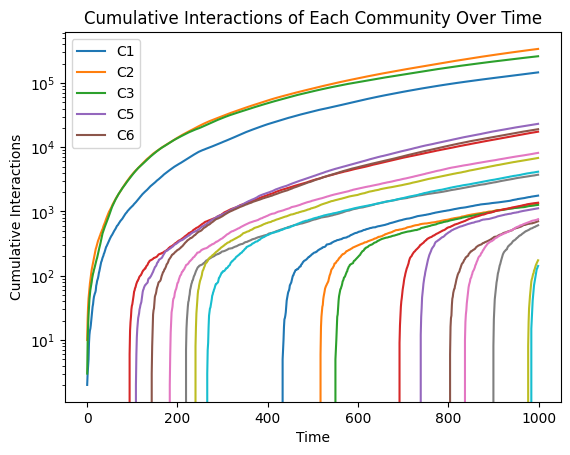

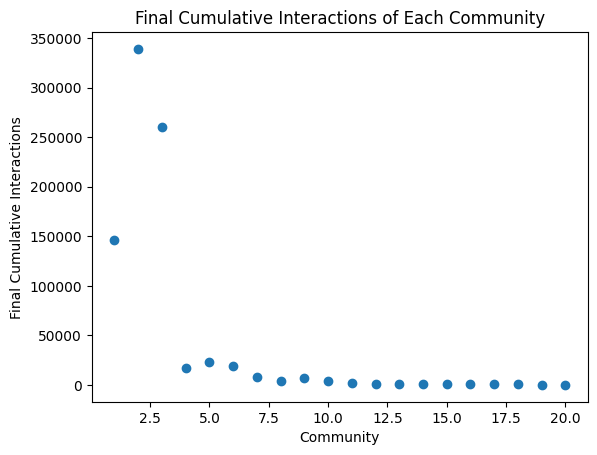

2 25393
3 21500
4 18845
5 15315
6 19893


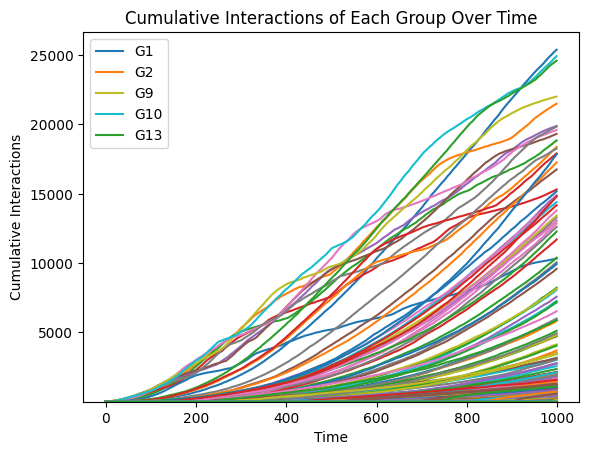

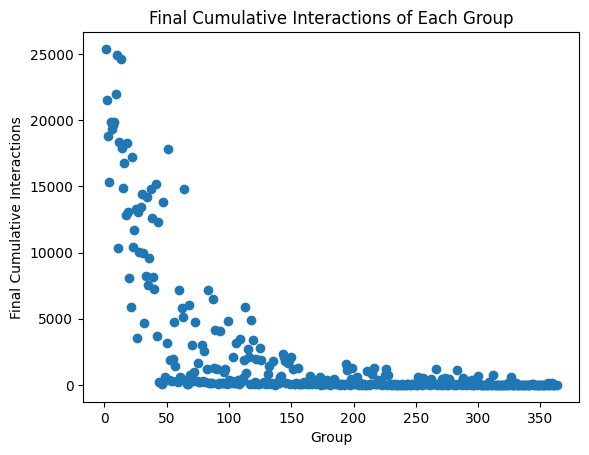

2 1112
3 1109
4 1113
5 1110
6 1108


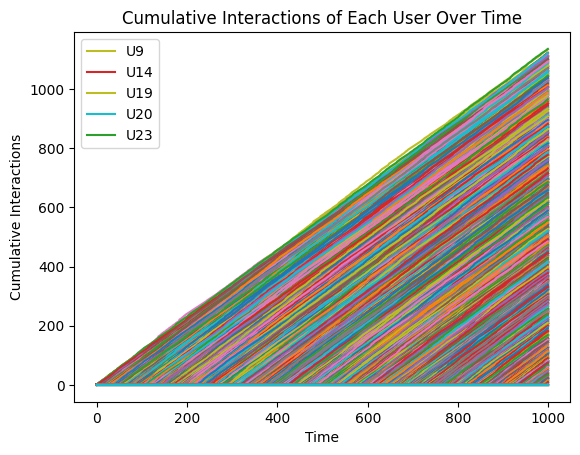

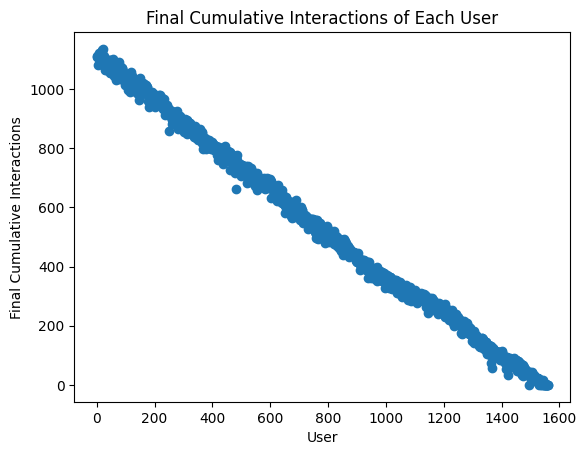

In [353]:
while True: # plotting the cumulative interactions of each community over time
    # printing the cumulative interactions of each community over time
    c_sum = []
    c_sum_labels = []
    for i in range(len(communities)):
        temp_sum = [0] * num_timesteps
        c_vals = np.cumsum(cis[i+1])
        # add the values starting from the back
        for j, val in enumerate(reversed(c_vals)):
            temp_sum[-1-j] = val
        c_sum.append(temp_sum)
        c_sum_labels.append(list(cis.keys())[i])

    # print the final value for each community
    for c in c_sum_labels[:5]:
        print(c, c_sum[c_sum_labels.index(c)][-1])
        
    # finding the labels for the 5 largest communities
    top_5 = []
    top_5_labels = []
    for i in range(5):
        max_val = 0
        max_index = 0
        for j in range(len(c_sum)):
            if c_sum[j][-1] > max_val and c_sum_labels[j] not in top_5_labels:
                max_val = c_sum[j][-1]
                max_index = j
        top_5.append(c_sum[max_index])
        top_5_labels.append(c_sum_labels[max_index])

    for i in range(len(c_sum)):
        if c_sum_labels[i] in top_5_labels:
            plt.plot(c_sum[i][:len(c_sum[i])], label=f"C{i+1}")
        else:
            plt.plot(c_sum[i][:len(c_sum[i])], label=None)

    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Interactions")
    plt.yscale("log")
    plt.title("Cumulative Interactions of Each Community Over Time")
    plt.show()
    
    # Scatter plot for final amount of interactions for each community
    c_sum_final = []
    c_sum_final_labels = []
    for i in range(len(communities)):
        c_sum_final.append(c_sum[i][-1])
        c_sum_final_labels.append(list(cis.keys())[i])

    plt.scatter(c_sum_final_labels, c_sum_final)
    plt.xlabel("Community")
    plt.ylabel("Final Cumulative Interactions")
    plt.title("Final Cumulative Interactions of Each Community")
    plt.show()    
    break

while True: # plotting the cumulative interactions of each group over time
    g_sum = []
    g_sum_labels = []
    for i in range(1, len(groups)):
        temp_sum = [0] * num_timesteps
        g_vals = np.cumsum(gis[i])
        # add the values starting from the back
        for j, val in enumerate(reversed(g_vals)):
            try:
                temp_sum[j] = val
            except:
                pass

        temp_sum = temp_sum[::-1]
        g_sum.append(temp_sum)
        g_sum_labels.append(list(gis.keys())[i])

    # print the final value for each group
    for g in g_sum_labels[:5]:
        print(g, g_sum[g_sum_labels.index(g)][-1])

    # finding the labels for the 5 largest groups
    top_5 = []
    top_5_labels = []
    for i in range(5):
        max_val = 0
        max_index = 0
        for j in range(len(g_sum)):
            if g_sum[j][-1] > max_val and g_sum_labels[j] not in top_5_labels:
                max_val = g_sum[j][-1]
                max_index = j
        top_5.append(g_sum[max_index])
        top_5_labels.append(g_sum_labels[max_index])

    for i in range(len(g_sum)):
        if g_sum_labels[i] in top_5_labels:
            plt.plot(g_sum[i], label=f"G{i+1}")
        else:
            plt.plot(g_sum[i], label=None)

    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Interactions")
    # plt.yscale("log")
    plt.ylim(bottom=1)
    plt.title("Cumulative Interactions of Each Group Over Time")
    plt.show()

    # Scatter plot for final amount of interactions for each group
    g_sum_final = []
    g_sum_final_labels = []
    for i in range(len(g_sum)):
        g_sum_final.append(g_sum[i][-1])
        g_sum_final_labels.append(list(gis.keys())[i])

    plt.scatter(g_sum_final_labels, g_sum_final)
    plt.xlabel("Group")
    plt.ylabel("Final Cumulative Interactions")
    plt.title("Final Cumulative Interactions of Each Group")
    plt.show()
    break

while True: # plotting the cumulative interactions of each user over time
    # trim so each user has length of num_timesteps
    for u in uis:
        uis[u] = uis[u][:num_timesteps]

    # plotting total amount of interactions for each user
    u_sum = []
    u_sum_labels = []
    for i in range(1, len(users)):
        temp_sum = [0] * num_timesteps
        u_vals = np.cumsum(uis[i])
        # add the values starting from the back
        for j, val in enumerate(reversed(u_vals)):
            temp_sum[j] = val

        temp_sum = temp_sum[::-1]
        u_sum.append(temp_sum)
        u_sum_labels.append(list(uis.keys())[i])

    # print the final value for each user
    for u in u_sum_labels[:5]:
        print(u, u_sum[u_sum_labels.index(u)][-1])

    # finding the labels for the 5 largest users
    top_5 = []
    top_5_labels = []

    for i in range(5):
        max_val = 0
        max_index = 0
        for j in range(len(u_sum)):
            if u_sum[j][-1] > max_val and u_sum_labels[j] not in top_5_labels:
                max_val = u_sum[j][-1]
                max_index = j
        top_5.append(u_sum[max_index])
        top_5_labels.append(u_sum_labels[max_index])

    for i in range(len(u_sum)):
        if u_sum_labels[i] in top_5_labels:
            plt.plot(u_sum[i], label=f"U{i+1}")
        else:
            plt.plot(u_sum[i], label=None)

    plt.legend(loc="upper left")
    plt.xlabel("Time")
    plt.ylabel("Cumulative Interactions")
    plt.title("Cumulative Interactions of Each User Over Time")
    plt.show()

    # Scatter plot for final amount of interactions for each user
    u_sum_final = []
    u_sum_final_labels = []
    for i in range(len(u_sum)):
        u_sum_final.append(u_sum[i][-1])
        u_sum_final_labels.append(list(uis.keys())[i])

    plt.scatter(u_sum_final_labels, u_sum_final)
    plt.xlabel("User")
    plt.ylabel("Final Cumulative Interactions")
    plt.title("Final Cumulative Interactions of Each User")
    plt.show()
    break